First stress-test on recovering the input to a pulse, given the true poles. Lessons are learned with respect to unwanted high frequencies (in fact, `CenteredSincKernel` behavior) in $u(t)$: while these are just a suboptimal local explanation of the data, they can be suppressed effectively and rightly by using the correct prior bounds for $r$. $r_\min$ encodes the Nyquist limit, because our continous kernels produce data that is not bandlimited.

In [1]:
%run init.ipy
from dgf import core
from dgf import isokernels

from lib import lfmodel
from lib import klatt
from lib.util import normalize_power

fs = 10

2022-11-09 14:00:32.507922: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
def generate_u(noise_power):
    dt = 1/fs
    dt_hires = dt/100
    LF_params = lfmodel.fant_params("male vowel")
    T0 = LF_params['T0']
    t = np.linspace(0, T0, int(T0/(dt_hires)))
    u = lfmodel.dgf(t, LF_params)
    every = int(dt/dt_hires)
    t = t[::every]
    u = u[::every]
    u = u + sqrt(noise_power)*randn(len(u))
    u = normalize_power(u)
    return t, u, LF_params

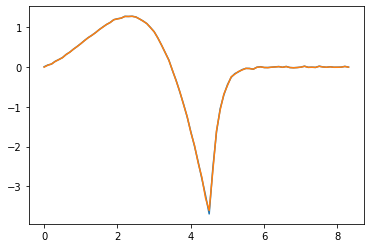

In [3]:
M = 150
c = 2.
noise_power = 1e-5

t, u, LF_params = generate_u(noise_power)
plot(t, u)

kernel = isokernels.Matern32Kernel
T = LF_params["T0"]
r = 1/pi

theta = {
    'T': T,
    'var': 1.,
    'scale': r*T,
    'noise_power': noise_power
}


def kernelmatrix_root_gfd(theta):
    R = core.kernelmatrix_root_gfd(
        kernel, theta['var'], theta['scale'],
        t, M, theta['T'], c
    )
    return R

R = kernelmatrix_root_gfd(theta)

def lstsq(R, y, noise_power):
    D = jnp.eye(R.shape[1])
    Z = noise_power * D + R.T @ R
    L, lower = jax.scipy.linalg.cho_factor(Z, lower=True, check_finite=False)
    b = R.T @ y
    x = jax.scipy.linalg.cho_solve((L, lower), b, check_finite=False)
    return x

x = lstsq(R, u, noise_power)
mean = R @ x
plot(t, mean)

In [4]:
def generate_speech(v, noise_power, pad=10.):
    dt = 1/fs
    dt_hires = dt/100
    LF_params = lfmodel.fant_params("male vowel")
    T = LF_params['T0'] + pad
    t = np.linspace(0, T, int(T/(dt_hires)))
    u = lfmodel.dgf(t, LF_params)
    t, d = klatt.gen_vowel(v, u, t, normalize_power=True)
    every = int(dt/dt_hires)
    t = t[::every]
    u = u[::every]
    d = d[::every]
    d = d + sqrt(noise_power)*randn(len(d))
    d, multiplier = normalize_power(d, return_multiplier=True) # Renormalize
    u *= multiplier
    return t, u, d, LF_params

def get_true_bandwidths(v):
    return np.fromiter((klatt.vowels.loc[v][f"B{i}"] for i in (1,2,3)), dtype=float64)

def get_true_frequencies(v):
    return np.fromiter((klatt.vowels.loc[v][f"F{i}"] for i in (1,2,3)), dtype=float64)

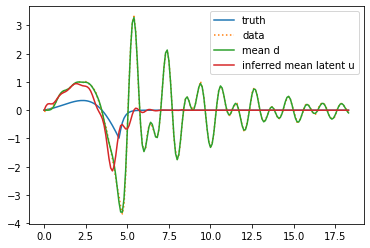

In [5]:
v = 26
c = 2.
noise_power = 1e-3

t, u, d, LF_params = generate_speech(v, noise_power)
dt = t[1] - t[0]

plot(t, u, label="truth")
plot(t, d, ':', label="data")

kernel = isokernels.Matern32Kernel
T = LF_params["T0"]
r = 1/pi

theta = {
    'T': T,
    'var': 1.,
    'scale': r*T,
    'bandwidth': get_true_bandwidths(v),
    'frequency': get_true_frequencies(v),
    'noise_power': noise_power
}

def kernelmatrix_root_convolved_gfd(theta):
    poles = core.make_poles(theta['bandwidth'], theta['frequency'])
    R = core.kernelmatrix_root_convolved_gfd(
        kernel, theta['var'], theta['scale'],
        t, M, theta['T'], c, poles
    )
    return R

Ru = kernelmatrix_root_gfd(theta)
Rd = kernelmatrix_root_convolved_gfd(theta)

mean_x = lstsq(Rd, d, noise_power)
covar_x = noise_power*jnp.linalg.inv(R.T @ R + (1/noise_power)*jnp.eye(R.shape[1]))
mean_d = Rd @ mean_x
mean_u = Ru @ mean_x
plot(t, mean_d, label="mean d")
plot(t, mean_u, label="inferred mean latent u")
legend();

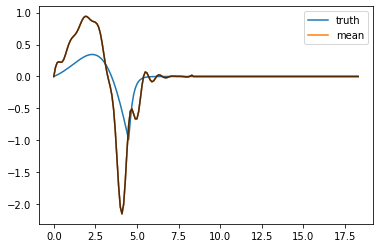

In [6]:
plot(t, u, label='truth')
plot(t, Ru @ mean_x, label='mean')
k = 10
for i in range(k):
    x = random.multivariate_normal(mean_x, covar_x)
    plot(t, Ru @ x, color='black', alpha=1/k)
legend()

(-5.0, 5.0)

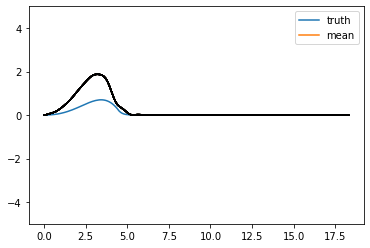

In [7]:
def integrate(x): return cumsum(x)*dt

plot(t, integrate(u), label='truth')
plot(t, integrate(Ru @ mean_x), label='mean')
k = 100
for i in range(k):
    x = random.multivariate_normal(mean_x, covar_x)
    plot(t, integrate(Ru @ x), color='black', alpha=10/k)
legend()
ylim(-5, 5)

In [61]:
import jax.scipy.optimize
from scipy.stats import multivariate_normal

def get_theta(x):
    var, r, noise_power = jnp.exp(x)
    theta = {
        'T': T,
        'var':var,
        'scale': r*T,
        'bandwidth': get_true_bandwidths(v),
        'frequency': get_true_frequencies(v),
        'noise_power': noise_power
    }
    return theta

def get_Rd(x):
    Rd = kernelmatrix_root_convolved_gfd(get_theta(x))
    return Rd

def get_Ru(x):
    Rd = kernelmatrix_root_gfd(get_theta(x))
    return Rd

def obj(x):
    noise_power = get_theta(x)['noise_power']
    return -core.loglikelihood_hilbert(get_Rd(x), d, noise_power)

# Give ridicilous starting point to lure out "inconsistent" solutions
x0 = jnp.log(jnp.array([1000., 1/jnp.pi/1000, 1e-3])) + randn(3)*2
res = jax.scipy.optimize.minimize(obj, x0, method="bfgs")

display(res.status)
get_theta(res.x)

DeviceArray(5, dtype=int64, weak_type=True)

{'T': 8.333333333333334,
 'var': DeviceArray(0.4550843, dtype=float64),
 'scale': DeviceArray(0.10733909, dtype=float64),
 'bandwidth': array([ 80.,  50., 130.]),
 'frequency': array([ 550.,  960., 2400.]),
 'noise_power': DeviceArray(0.00091686, dtype=float64)}

#### Minimization outcomes

- Often, `res.status == 0` and good results. We're off by a constant factor of about 2; normally an extra pole would take care of the scaling. But we generally work modulo rescaling anyway.
- `res.status == 5` and nans in `res`: line search failed; to close to very sharp maximum
- `res.status == 0` and very high `var` and very small `scale`: no decay in basis function power (in other words: the `CenteredSincKernel` on a full bandwidth); the $u(t)$ estimate consists of a correct low-frequency trend plus high-frequency white noise. The convolution still produces the correct data because the high frequencies are damped by the low-pass transfer function, such that introducing high frequencies cannot be prevented by the data. But why does the GP want to do this locally (i.e. this is not globally optimal but is some local explanation)? I'm not entirely sure, but *note that this is just a local optimum and has lower likelihood than the correct solution* **and** is outside of the prior support, so not a real problem. My guess is that the local explanation is: "a CenteredSincKernel with a very large amplitude can explain this as well", and indeed, the Sinc kernel can fit various real-world signals without much parameter tuning [@Tobar2019]. The reason `var` is so large is that otherwise the `mean_x` components would have to be very large, and they have $N(0,1)$ priors preventing that. Thus assigning a prior to the variance `var` will effectively solve this problem.

SNR = 30.376975786724728


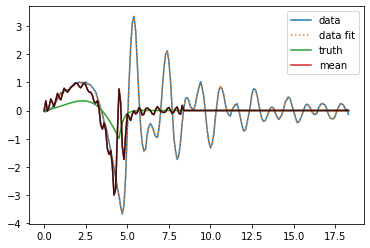

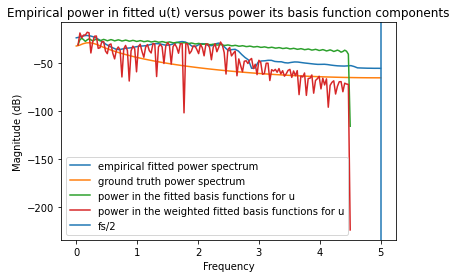

In [62]:
Rd_fit = get_Rd(res.x)
Ru_fit = get_Ru(res.x)

fit_noise_power = get_theta(res.x)['noise_power']
print("SNR =", -10*log10(fit_noise_power))

mean_x = lstsq(Rd_fit, d, fit_noise_power)
covar_x = fit_noise_power*jnp.linalg.inv(Rd_fit.T @ Rd_fit + (1/fit_noise_power)*jnp.eye(Rd_fit.shape[1]))

plot(t, d, label='data')
plot(t, Rd_fit @ mean_x, label='data fit', ls=':')
plot(t, u, label='truth')
plot(t, Ru_fit @ mean_x, label='mean')

k = 10
x = multivariate_normal(mean_x, covar_x, allow_singular=True).rvs(k).T
plot(t, Ru_fit @ x, color='black', alpha=1/k)
legend()

figure()
magnitude_spectrum(Ru_fit @ mean_x, Fs=fs, scale='dB', label="empirical fitted power spectrum");
magnitude_spectrum(u, Fs=fs, scale='dB', label="ground truth power spectrum");

def _power(R): return np.sum(R**2, axis=0)/R.shape[0]

s = jnp.arange(1, M+1)*jnp.pi/(c*T)/(2*pi) # This is the correct scaling in kHz
power = 10*log10(_power(Ru_fit))
power_x = 10*log10(_power(Ru_fit * mean_x))
plot(s, power, label="power in the fitted basis functions for u")
plot(s, power_x, label="power in the weighted fitted basis functions for u")
axvline(fs/2, label="fs/2")
title("Empirical power in fitted u(t) versus power its basis function components")
legend();
#ylim(power[-1], None);

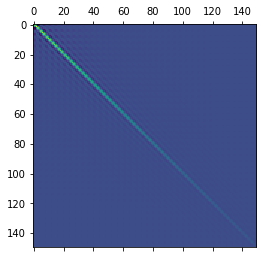

In [64]:
matshow((Ru_fit.T @ Ru_fit)[:,:])

In [19]:
import scipy.linalg

In [20]:
g = Ru_fit.T @ Ru_fit

In [69]:
def square_to_banded_lower(A, u): # This might contain errors >:(
    n = A.shape[0]
    def pad(x):
        return np.pad(x, (0, n - len(x)))
    
    return np.vstack([pad(np.diag(A, -offset)) for offset in range(u + 1)])

ab = square_to_banded_lower(g, 1)
ab[0,:] += 1e-6
scipy.linalg.cholesky_banded(ab, lower=True, check_finite=False)

LinAlgError: 6-th leading minor not positive definite